# `politician2vec` modelling pipeline

In [ ]:
# Make sure politician2vec is up to date
%pip uninstall politician2vec -y
%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

In [1]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
import multiprocessing
available_workers = multiprocessing.cpu_count()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs.p'

In [169]:
# We remove North-Atlantic politicians due to them skewing the corpus with very few, concentrated observations
parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP']")
parl_data.shape

(91839, 6)

In [170]:
parl_data['party'].value_counts()

S      21917
V      14393
DF     12163
EL      9449
SF      7007
KF      6081
RV      5361
NB      5164
LA      4488
ALT     3063
UFG     1294
KD       678
FG       643
DD       101
M         37
Name: party, dtype: int64

In [171]:
parl_data['party'].value_counts(dropna = False)

S      21917
V      14393
DF     12163
EL      9449
SF      7007
KF      6081
RV      5361
NB      5164
LA      4488
ALT     3063
UFG     1294
KD       678
FG       643
DD       101
M         37
Name: party, dtype: int64

In [172]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()

In [173]:
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [174]:
ngram_options = {
    'min_count': 5,
    'threshold': 1,
    'delimiter': '_'
}

In [175]:
pol2vec_model = Politician2Vec(
    documents = docs,
    custom_clusters = parties,
    party_inference_method = 'mean',
    tokenizer = tokenize_docs,
    embedding_model = 'doc2vec',
    min_count = 50, # consider setting this higher!
    ngram_vocab = True,
    ngram_vocab_args = ngram_options,
    speed = 'fast-learn', # CHANGE FOR REAL RUNS
    workers = available_workers
    #doc2vec_vector_size = 300,
    #doc2vec_window = 8,
    #doc2vec_samples_threshold = 1e-5
)

2023-03-07 17:03:09,045 - politician2vec - INFO - Pre-processing documents for training
2023-03-07 17:04:44,167 - politician2vec - INFO - Creating joint document/word embedding
2023-03-07 17:25:34,218 - politician2vec - INFO - Estimating party positions using mean...
2023-03-07 17:25:34,630 - politician2vec - INFO - All done!


In [176]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_party(politician2vec_model, party_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    party.
    -------
    manual_num (int):  automatically assigned party number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given party.
        Default is to print all docs within a given party.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of party docs.
    '''

    num_parties = politician2vec_model.get_num_parties()
    party_words, word_scores, party_nums = politician2vec_model.get_parties(num_parties)

    # Get party sizes so we know max n docs
    party_sizes, party_nums = politician2vec_model.get_party_sizes()
    docs_to_return = party_sizes[party_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input party id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_party(
        party_num=party_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of party docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', party_words[party_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [177]:
word_vectors = pol2vec_model.model.wv
word_vectors.most_similar(positive = ['uværdig'], topn = 25)

[('værdig', 0.3832789659500122),
 ('else', 0.32229331135749817),
 ('værdighed', 0.31641533970832825),
 ('ordentlig', 0.29976585507392883),
 ('uværdigt', 0.2953217625617981),
 ('pensionsalderen', 0.2891260087490082),
 ('seniorførtidspension', 0.28687620162963867),
 ('pensionsalder', 0.2863250970840454),
 ('folkepensionsalderen', 0.28424981236457825),
 ('ældre', 0.28309574723243713),
 ('mennesker', 0.28256890177726746),
 ('nedslidte', 0.28208813071250916),
 ('retten', 0.276796817779541),
 ('empati', 0.2690039575099945),
 ('nedslidt', 0.26814454793930054),
 ('mogens', 0.26537495851516724),
 ('omsorg', 0.26300254464149475),
 ('alderdom', 0.26166388392448425),
 ('inger', 0.25649696588516235),
 ('frederik', 0.2561950385570526),
 ('støjbergs', 0.2540907561779022),
 ('værdigt', 0.25183945894241333),
 ('plejehjem', 0.2481115609407425),
 ('mentalt', 0.24809545278549194),
 ('pleje', 0.2477843016386032)]

In [183]:
inspect_party(pol2vec_model, 0, n_docs=1, query_substr=None)

--- TOP 50 WORDS ---
 ['sikrer gode' 'samtidig afgørende' 'mindst grund' 'samtidig give'
 'gælder både' 'gælder bla' 'står sammen' 'samtidig sikre'
 'således sikrer' 'samtidig sætter' 'sikre god' 'samtidig ser'
 'fortsat sikre' 'bla sikre' 'samtidig sikrer' 'samtidig styrke'
 'indsats forbindelse' 'mulige gode' 'tvangsfordelingsmodel baggrund'
 'sikrer mere' 'samtidig oplever' 'dermed bedre' 'sikre større'
 'ret vigtige' 'optaget laver' 'samtidig får' 'både gælder'
 'derudover vigtigt' 'blevet bedre' 'dermed givet' 'forbindelse kommende'
 'sikrer bedst' 'derudover handler' 'gerne følge' 'netop sikre'
 'to vigtige' 'første vigtige' 'sikre gode' 'se stort' 'sammen optaget'
 'bla grund' 'helt alene' 'gerne sikre' 'afgørende vigtige'
 'allerede inde' 'behov særlig' 'arbejde længere' 'derfor forstår'
 'optaget styrke' 'samtidig siger'] 

--- TOP 1 DOCS. SUBSTRING QUERY: None (n = 1) ---
 ['jeg vil egentlig gerne tage fat på noget af det som ordføreren sagde i talen nemlig at man fra liberal

In [179]:
model_path = 'embedding_models/OLD/politician2vec_test_parl_v1.txt'#
#model_path = 'embedding_models/politician2vec_meta_deeplearn_v1.txt'
model_path = 'embedding_models/fastlearn_v1.txt'
#model_path = 'embedding_models/politician2vec_tw_fastlearn_preproc.txt'

In [180]:
pol2vec_model.save(model_path)

_____

## Viz dev

In [181]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [185]:
n_words = len(doc2vec_model.wv)
n_docs = len(doc2vec_model.dv)
vocab = pol2vec_model.vocab

In [220]:
## PARLIAMENT FASTLEARN
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'SF',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'UFG',
   9: 'Alternativet',
   10: 'Danmarksdemokraterne',
   11: 'Nye Borgerlige',
   12: 'Frie Grønne',
   13: 'Moderaterne',
   14: 'Kristendemokraterne'
}

In [163]:
# Hack to make top2vec models compatible with pol2vec
# def rename_attribute(obj, old_name, new_name):
#     obj.__dict__[new_name] = obj.__dict__.pop(old_name)

# rename_attribute(pol2vec_model, old_name='doc_top', new_name='doc_party')

In [187]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party sizes before filtering (party 19 is "Other"):

[[ 0 48]
 [ 1 44]
 [ 2 36]
 [ 3 16]
 [ 4 15]
 [ 5 15]
 [ 6 14]
 [ 7 13]
 [ 8 11]
 [ 9 11]
 [10  5]
 [11  4]
 [12  3]
 [13  1]
 [14  1]]


In [79]:
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

In [188]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [189]:
party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

In [228]:
party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())

In [234]:
#party_labels = party_df.drop_duplicates(keep = 'last', subset = 'party')[['party', 'party']].sort_values(by = 'party').set_index('party').reset_index(drop=True)

party_labels = party_df.drop_duplicates(keep = 'last', subset = 'party').sort_values(by='rank', ascending=False)#[['party', 'party']].sort_values(by = 'party').set_index('party').reset_index(drop=True)

In [235]:
party_labels

,doc,party,snippet,color,full_name,rank
235,235,S,tak for det og tak til ordføreren for talen or...,#C8042C,Yildiz Akdogan,51
233,233,V,lad mig starte med at slå fast at jeg er meget...,#1A4289,Ulla Tørnæs,43
217,217,DF,dansk presse var engang velsignet med en fremr...,#265BA4,Søren Espersen,34
219,219,EL,tak for det det er jo ikke nogen hemmelighed a...,#BF2850,Søren Søndergaard,16
226,226,SF,tak for det sf er positive over for forslaget ...,#B42D27,Trine Torp,15
236,236,RV,tak for det jeg skal bare allerførst starte me...,#D82E8A,Zenia Stampe,15
218,218,KF,tak for det og tak for spørgsmålet jeg har ful...,#24573E,Søren Pape Poulsen,14
234,234,LA,med det her lovforslag afskaffer vi jo reelt v...,#E7B657,Villum Christensen,13
231,231,UFG,det er bare for lige at give ros til ministere...,lightgrey,Uffe Elbæk,11
232,232,ALT,mange tak og tak til regeringen for redegørels...,#75FB4C,Ulla Sandbæk,11


In [236]:
partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

In [237]:
partylabels

,party
235,S
233,V
217,DF
219,EL
226,SF
236,RV
218,KF
234,LA
231,UFG
232,ALT


In [238]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

In [239]:
combined_hover

,doc,party,snippet,color,full_name,rank
0,0.0,DF,tak det åbne spørgsmål er jo hvad socialdemokr...,#265BA4,Alex Ahrendtsen,34.0
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,51.0
3,3.0,LA,tak for det og tak for en saglig og konstrukti...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,i radikale venstre forstår vi lovforslaget såd...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
247,NaN,DD,NaN,black,NaN,NaN
248,NaN,NB,NaN,black,NaN,NaN
249,NaN,FG,NaN,black,NaN,NaN
250,NaN,KD,NaN,black,NaN,NaN


In [240]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=3
    ).fit(
        np.vstack([
            pol2vec_model.document_vectors,
            pol2vec_model.party_vectors
            ])
    ) # label supervision: y = combined_hover['party'].astype('category').cat.codes

In [241]:
pol2vec_model.model.wv.most_similar(negative = ['saglig'], topn = 50)

[('fastslået', 0.135247603058815),
 ('opkræves', 0.12462101876735687),
 ('sidestilles', 0.1235443651676178),
 ('afviklet', 0.1196318194270134),
 ('thor', 0.11859284341335297),
 ('kræft', 0.11636031419038773),
 ('afsavn', 0.11301200836896896),
 ('efterlever', 0.10725193470716476),
 ('rettere', 0.10667978227138519),
 ('solidariske', 0.10074284672737122),
 ('overraskede', 0.10069140791893005),
 ('usikre', 0.10006682574748993),
 ('pukkel', 0.0991644486784935),
 ('derudad', 0.098732590675354),
 ('efterlade', 0.09740125387907028),
 ('skoleår', 0.09633662551641464),
 ('lykkelige', 0.09482560306787491),
 ('pludselig', 0.09428443014621735),
 ('panik', 0.09379316121339798),
 ('døren', 0.09209932386875153),
 ('overvejelserne', 0.0907658189535141),
 ('nærmeste', 0.09069615602493286),
 ('etableringen', 0.09065236896276474),
 ('strømmen', 0.08950331062078476),
 ('nervøse', 0.08838433027267456),
 ('vendte', 0.087548166513443),
 ('kompensationen', 0.0857897475361824),
 ('rykkede', 0.08417879045009613)

In [242]:
UMAP_projections = []

for seed in tqdm(range(0,1)):

    politician_mapper = umap.UMAP(
        n_neighbors=15,
        metric='cosine',
        n_components=3,
        random_state=seed
        ).fit(
            np.vstack([
                pol2vec_model.document_vectors,
                pol2vec_model.party_vectors
                ])
        )

    words_reduced = politician_mapper.transform(
        pol2vec_model.word_vectors
            )

    UMAP_projections.append((politician_mapper, words_reduced))

  0%|          | 0/1 [00:00<?, ?it/s]

In [243]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-whitegrid')
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

In [244]:
combined_hover[237:252]

,doc,party,snippet,color,full_name,rank
237,NaN,S,NaN,black,NaN,NaN
238,NaN,V,NaN,black,NaN,NaN
239,NaN,DF,NaN,black,NaN,NaN
240,NaN,EL,NaN,black,NaN,NaN
241,NaN,SF,NaN,black,NaN,NaN
242,NaN,RV,NaN,black,NaN,NaN
243,NaN,KF,NaN,black,NaN,NaN
244,NaN,LA,NaN,black,NaN,NaN
245,NaN,UFG,NaN,black,NaN,NaN
246,NaN,ALT,NaN,black,NaN,NaN


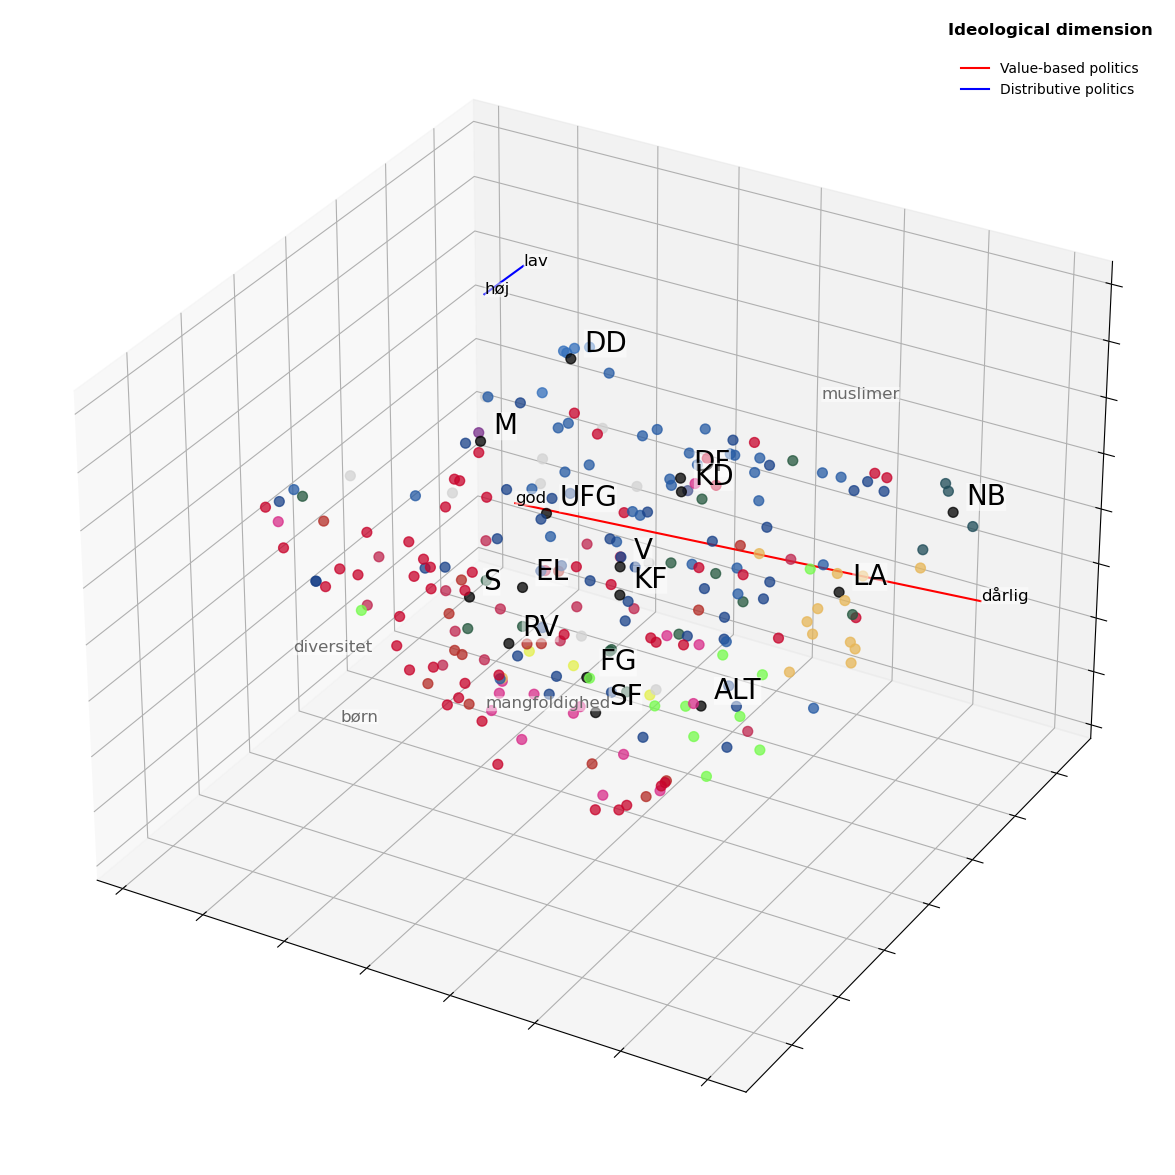

In [245]:
# Learning a 2D mapping of politician/party vectors and projecting words onto this "party space".
# Note that this is purely for visualisation purposes, since both words and documents are already
# embedded in the original 300D space--however, simply reducing the entire space at once runs the
# risk of the model distinguishing too clearly between word vecs and doc vecs and therfore placing
# them too far apart from each other.


for politician_mapper, words_reduced in UMAP_projections[0:1]:

    words_to_draw = [
        'mangfoldighed',
        'børn',
        'høj',
        'lav',
        'god',
        'dårlig',
        'muslimer',
        'diversitet'
    ]

    class PopulismWords:
        def __init__(self, projected_words, words_to_draw: 'list', antonym_pairs: 'list of tuples'):
            self.projection = projected_words
            self.vocab = words_to_draw
            self.antonyms = antonym_pairs
            self.word_coords = []

            for word in words_to_draw:
                self.word_coords.append(self.get_word_coords(word, self.projection))

        def get_word_coords(self, word, projected_words):
            idx = pol2vec_model.vocab.index(word)
            word_pos = projected_words[idx]

            return word_pos

        def get_antonym_coords(self, idx):
            antonym_coords = []
            pair = self.antonyms[idx]
            
            for word in pair:
                antonym_coords.append(self.get_word_coords(word, self.projection))

                xyz_coords = np.vstack(antonym_coords).T

            return xyz_coords[0], xyz_coords[1], xyz_coords[2]
        
        def write_words(self, ax):

            for word, word_pos in zip(self.vocab, self.word_coords):

                text_args = {
                'x': word_pos[0],
                'y': word_pos[1],
                'z': word_pos[2],
                'size': 12,
                'color': 'black',
                'bbox': dict(
                        facecolor='white',
                        alpha = .5,
                        edgecolor='none',
                        boxstyle='round,pad=0'
                        )
                    }

                if word in populism_words.antonyms[0]+populism_words.antonyms[len(populism_words.antonyms)-1]:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = text_args['color'],
                        bbox=text_args['bbox']
                    )

                else:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = 'dimgrey',
                        bbox=text_args['bbox']
                    )

        def draw_antonym_line(self, idx, ax, color = 'g', label = 'label here'):
            x, y, z = self.get_antonym_coords(idx)

            ax.plot(
                x,
                y,
                z,
                color = color,
                label = label
            )
            
    populism_words = PopulismWords(
        words_reduced,
        words_to_draw,
        antonym_pairs = [
            ('god', 'dårlig'),
            ('høj', 'lav')
            ]
        )
    # TWITTER WORD SPACE MAPPING
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    xdata = politician_mapper.embedding_.T[0]
    ydata = politician_mapper.embedding_.T[1]
    zdata = politician_mapper.embedding_.T[2]

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.scatter3D(
        xdata,
        ydata,
        zdata,
        c=combined_hover['color'],
        cmap=combined_hover['color'],
        alpha = 0.75,
        s = 50
        )

    for vec_idx in range(237,252):
        x = politician_mapper.embedding_[vec_idx].T[0]
        y = politician_mapper.embedding_[vec_idx].T[1]
        z = politician_mapper.embedding_[vec_idx].T[2]
        
        ax.text(
            x+0.05,
            y+0.05,
            z+0.05,
            combined_hover.iloc[vec_idx]['party'],
            size=20,
            bbox=dict(
                facecolor='white',
                alpha = .5,
                edgecolor='none',
                boxstyle='round,pad=0'
                )
            )

    populism_words.write_words(ax)
    populism_words.draw_antonym_line(0, ax, color = 'r', label = 'Value-based politics')
    populism_words.draw_antonym_line(1, ax, color = 'b', label = 'Distributive politics')
    #populism_words.draw_antonym_line(2, ax, color = 'b', label = 'inclusive politics/moralised politics')

    plt.legend(
        title = 'Ideological dimension\n',
        frameon = False,
        title_fontproperties={
            'size': 'large',
            'weight':'bold'
            }
        )

    #plt.savefig(f'/Users/mathiasbruun/Downloads/output_classic_seed_{seed}.png')
    
    plt.show()

In [ ]:
   # POPULISM TERMS
    #     'danske værdier',
    #     'internationalt samarbejde',
    #     'folkevalgte',
    #     'løgn',
    #     'sandhed',
    #     'onde',
    #     'forkert',
    #     'enighed',
    #     'dansk',
    #     'fair',
    #     'retfærdig',
    #     'skamme',
    #     'usandt',
    #     'ærlig',
    #     'skuffende',
    #     'danske statsborgere',
    #     'vilje',
    #     'værdi',
    #     'diversitet',
    #     'hårdtarbejdende',
    #     'vælgerne',
    #     'folket',
    #     'ligeglad',
    #     'selvbestemmelse',
    #     'byde velkommen'

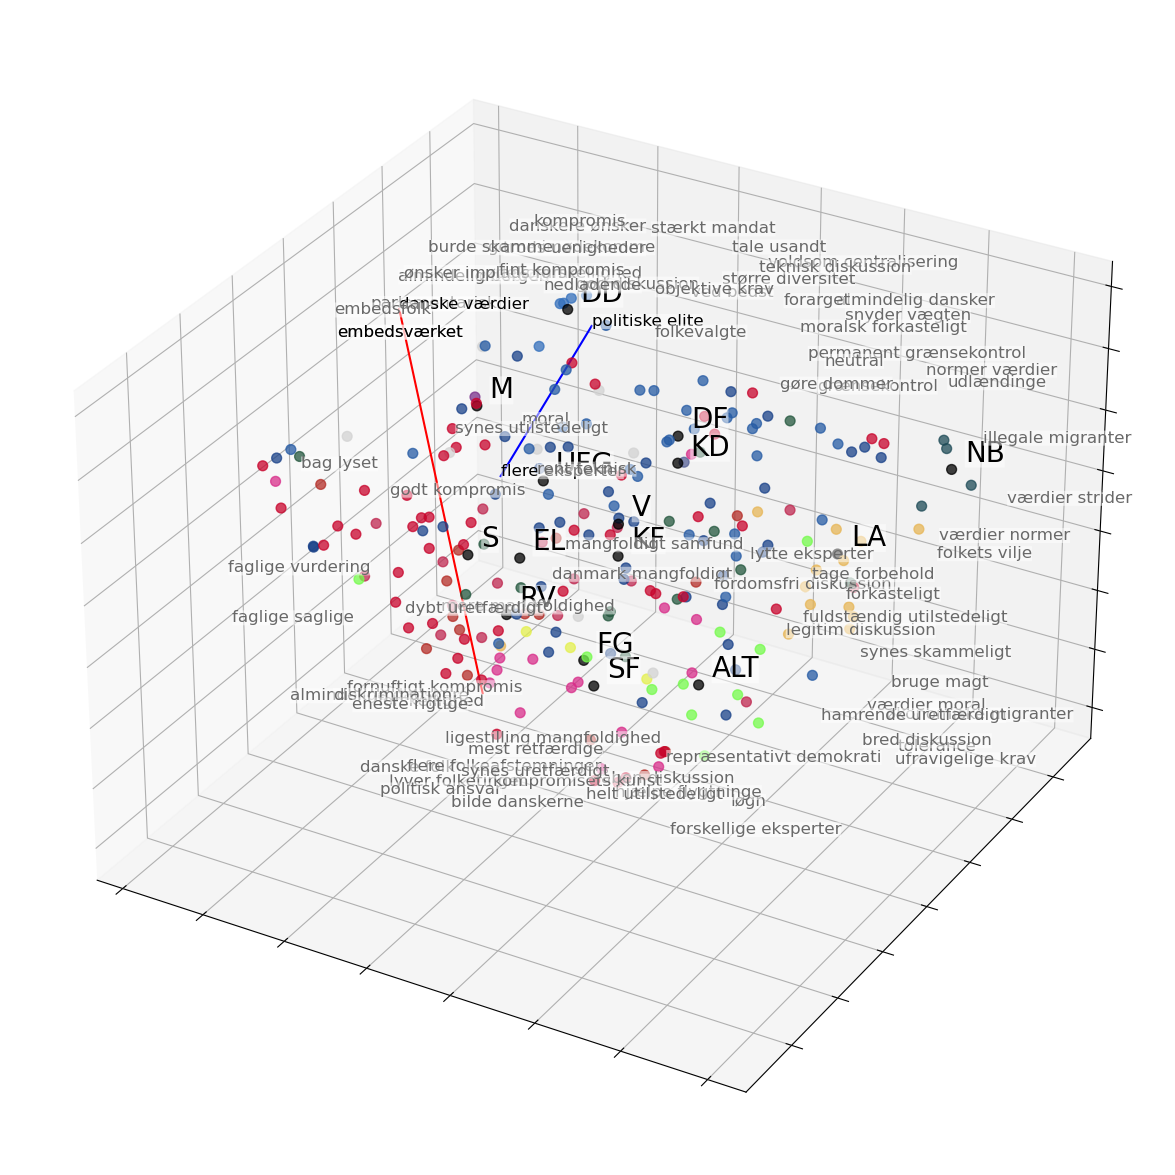

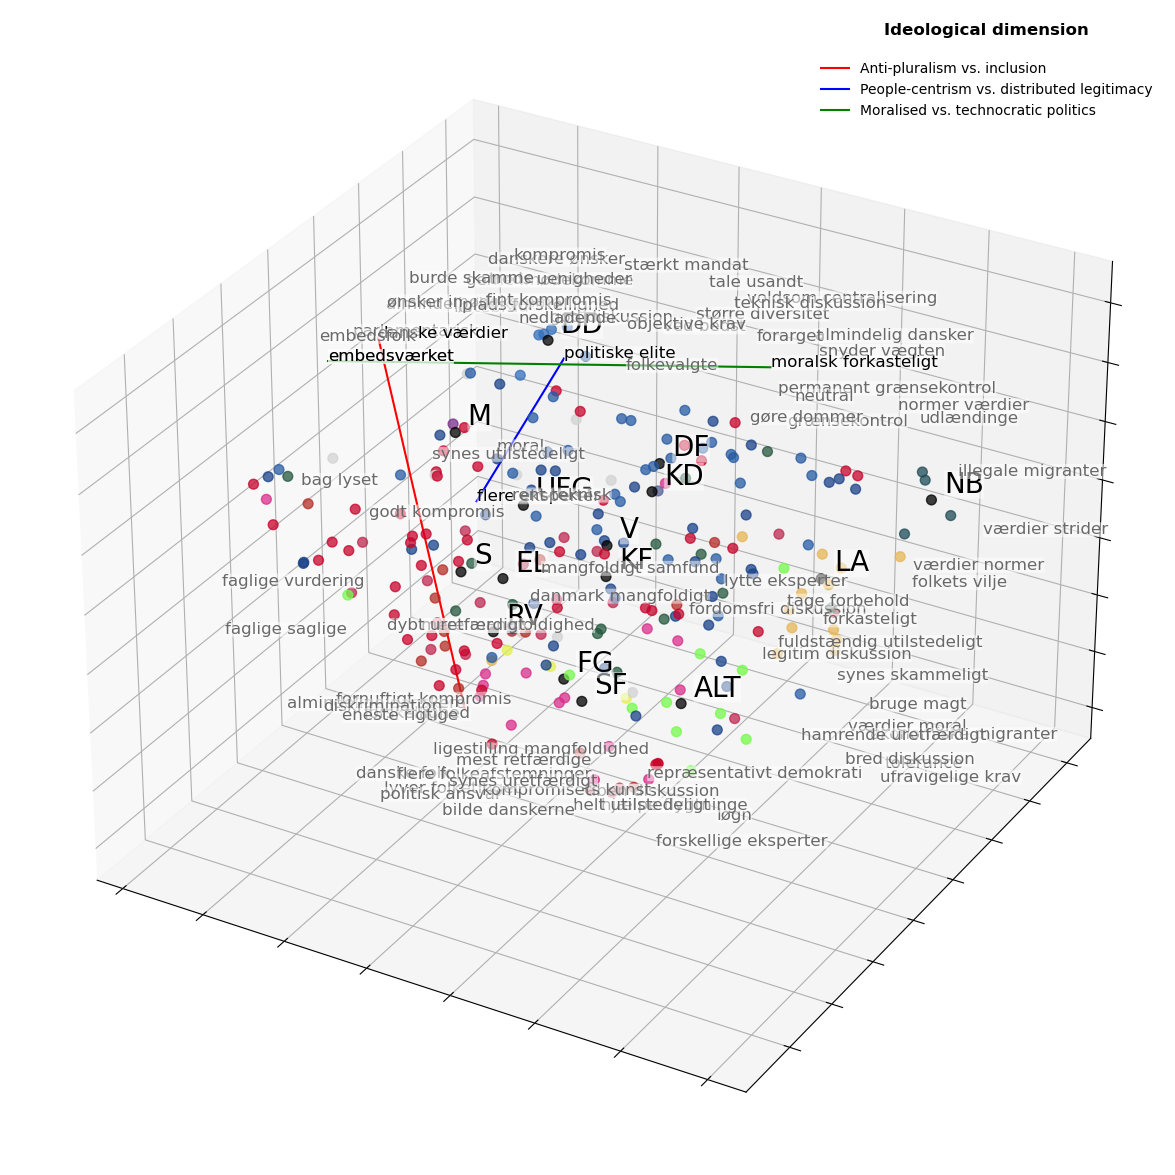

In [350]:
# Learning a 2D mapping of politician/party vectors and projecting words onto this "party space".
# Note that this is purely for visualisation purposes, since both words and documents are already
# embedded in the original 300D space--however, simply reducing the entire space at once runs the
# risk of the model distinguishing too clearly between word vecs and doc vecs and therfore placing
# them too far apart from each other.


for politician_mapper, words_reduced in UMAP_projections[0:1]:

    words_to_draw = [
        # PC
        'løgn',
        'lyver folketinget',
        #'uærlig',
        'tale usandt',
        #'usandt folektinget',
        #'utopi',
        'voldsom centralisering',
        'løftebrud',
        'bag lyset',
        'politiske elite',
        'folkets vilje',
        'danske folk',
        'almindelige danskere',
        'almindelig dansker',
        'almindelig borger',
        'flere folkeafstemninger',
        'ved bedst',
        'danskere ønsker',

        # ---

        'repræsentativt demokrati',
        'lytte eksperter',
        'flere eksperter',
        'forskellige eksperter',
        'politisk ansvar',
        'folkevalgte',
        'parlamentarisk',
        'stærkt mandat',

        # AP
        'danske værdier',
        'normer værdier',
        'grænsekontrol',
        'permanent grænsekontrol',
        'illegale migranter',
        'økonomiske migranter',
        'ufravigelige krav',
        'udlændinge',

        # ---

        'større diversitet',
        'mere mangfoldighed',
        'danmark mangfoldigt',
        'ligestilling mangfoldighed',
        'mangfoldigt samfund',
        'tolerance',
        'ønsker imødekomme',
        'gerne imødekomme',
        'plads forskellighed',
        'forskellighed',
        'trods uenigheder',
        'åben diskussion',
        'bred diskussion',
        'fordomsfri diskussion',
        'god diskussion',
        'legitim diskussion',
        'godt kompromis',
        'fint kompromis',
        'fornuftigt kompromis',
        'kompromisets kunst',
        'kompromis',
        'hjælpe flygtninge',
        'diskrimination',

        # MP
        'eneste rigtige',
        'bruge magt',
        'snyder vægten',
        'moralsk forkasteligt',
        'moral',
        'værdier normer',
        'værdier moral',
        'værdier strider',
        'synes skammeligt',
        'burde skamme',
        'forarget',
        'forkasteligt',
        'fuldstændig utilstedeligt',
        'helt utilstedeligt',
        'synes utilstedeligt',
        'dybt uretfærdigt',
        'synes uretfærdigt',
        'hamrende uretfærdigt',
        'mest retfærdige',
        'bilde danskerne',
        'nedladende',

        # ---

        'faglige saglige',
        'faglige vurdering',
        'rent teknisk',
        'teknisk diskussion',
        'embedsværket',
        'neutral',
        'embedsfolk',
        'embedsværket',
        'gøre dommer',
        'tage forbehold',
        'objektive krav'
    ]

    class PopulismWords:
        def __init__(self, projected_words, words_to_draw: 'list', antonym_pairs: 'list of tuples'):
            self.projection = projected_words
            self.vocab = words_to_draw
            self.antonyms = antonym_pairs
            self.word_coords = []

            for word in words_to_draw:
                self.word_coords.append(self.get_word_coords(word, self.projection))

        def get_word_coords(self, word, projected_words):
            idx = pol2vec_model.vocab.index(word)
            word_pos = projected_words[idx]

            return word_pos

        def get_antonym_coords(self, idx):
            antonym_coords = []
            pair = self.antonyms[idx]
            
            for word in pair:
                antonym_coords.append(self.get_word_coords(word, self.projection))

                xyz_coords = np.vstack(antonym_coords).T

            return xyz_coords[0], xyz_coords[1], xyz_coords[2]
        
        def write_words(self, ax):

            for word, word_pos in zip(self.vocab, self.word_coords):

                text_args = {
                'x': word_pos[0],
                'y': word_pos[1],
                'z': word_pos[2],
                'size': 12,
                'color': 'black',
                'bbox': dict(
                        facecolor='white',
                        alpha = .5,
                        edgecolor='none',
                        boxstyle='round,pad=0'
                        )
                    }

                if word in populism_words.antonyms[0]+populism_words.antonyms[len(populism_words.antonyms)-2]+populism_words.antonyms[len(populism_words.antonyms)-1]:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = text_args['color'],
                        bbox=text_args['bbox']
                    )

                else:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = 'dimgrey',
                        bbox=text_args['bbox']
                    )

        def draw_antonym_line(self, idx, ax, color = 'g', label = 'label here'):
            x, y, z = self.get_antonym_coords(idx)

            ax.plot(
                x,
                y,
                z,
                color = color,
                label = label
            )
            
    populism_words = PopulismWords(
        words_reduced,
        words_to_draw,
        antonym_pairs = [
            ('danske værdier', 'mangfoldighed'),
            ('politiske elite', 'flere eksperter'),
            ('moralsk forkasteligt','embedsværket')
            ]
        )
    # TWITTER WORD SPACE MAPPING
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    xdata = politician_mapper.embedding_.T[0]
    ydata = politician_mapper.embedding_.T[1]
    zdata = politician_mapper.embedding_.T[2]

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.scatter3D(
        xdata,
        ydata,
        zdata,
        c=combined_hover['color'],
        cmap=combined_hover['color'],
        alpha = 0.75,
        s = 50
        )

    for vec_idx in range(237,252):
        x = politician_mapper.embedding_[vec_idx].T[0]
        y = politician_mapper.embedding_[vec_idx].T[1]
        z = politician_mapper.embedding_[vec_idx].T[2]
        
        ax.text(
            x+0.05,
            y+0.05,
            z+0.05,
            combined_hover.iloc[vec_idx]['party'],
            size=20,
            bbox=dict(
                facecolor='white',
                alpha = .5,
                edgecolor='none',
                boxstyle='round,pad=0'
                )
            )

    populism_words.write_words(ax)
    populism_words.draw_antonym_line(0, ax, color = 'r', label = 'Anti-pluralism vs. inclusion')
    populism_words.draw_antonym_line(1, ax, color = 'b', label = 'People-centrism vs. distributed legitimacy')
    populism_words.draw_antonym_line(2, ax, color = 'g', label = 'Moralised vs. technocratic politics')
    plt.legend(
        title = 'Ideological dimension\n',
        frameon = False,
        title_fontproperties={
            'size': 'large',
            'weight':'bold'
            }
        )

    #plt.savefig(f'/Users/mathiasbruun/Downloads/output_classic_seed_{seed}.png')
    
    plt.show()

In [310]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [343]:
class Subdimension:
        def __init__(self, present_words, absent_words):
            self.words = {'present': present_words, 'absent': absent_words}
            self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
        
        def add_words(self, words, present = True):
            for word in words:
                self._add_word(word, present)
        
        def remove_words(self, words, present = True):
            for word in words:
                self._remove_word(word, present)

        # TODO: Make it impossible to add the same word twice...
        def _add_word(self, word, present = True):
            self.words['present' if present else 'absent'].append(word)
            self.vecs['present' if present else 'absent'].append(self.get_vec(word))

        def _remove_word(self, word, present = True):
            remove_idx = self.words['present' if present else 'absent'].index(word)
            self.words['present' if present else 'absent'].remove(word)
            del self.vecs['present' if present else 'absent'][remove_idx]

        def calc_subdim_vecs(self):
            return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent'])
        
        @staticmethod
        def get_vec(word):
            idx = pol2vec_model.word_indexes[word]
            vec = pol2vec_model.word_vectors[idx]
    
            return vec
        
        @staticmethod
        def mean_vec(vecs):
            return np.mean(vecs, axis=0)

In [351]:
PC_present_words = [
    'løgn',
    'lyver folketinget',
    #'uærlig',
    'tale usandt',
    #'usandt folektinget',
    #'utopi',
    'voldsom centralisering',
    'løftebrud',
    'bag lyset',
    'politiske elite',
    'folkets vilje',
    'danske folk',
    'almindelige danskere',
    'almindelig dansker',
    'almindelig borger',
    'flere folkeafstemninger',
    'ved bedst',
    'danskere ønsker'
    ]

PC_absent_words = [
    'repræsentativt demokrati',
    'lytte eksperter',
    'flere eksperter',
    'forskellige eksperter',
    'politisk ansvar',
    'folkevalgte',
    'parlamentarisk',
    'stærkt mandat'
    ]

AP_present_words = [
    'danske værdier',
    'normer værdier',
    'grænsekontrol',
    'permanent grænsekontrol',
    'illegale migranter',
    'økonomiske migranter',
    'ufravigelige krav',
    'udlændinge'
    ]

AP_absent_words = [
    'større diversitet',
    'mere mangfoldighed',
    'danmark mangfoldigt',
    'ligestilling mangfoldighed',
    'mangfoldigt samfund',
    'tolerance',
    'ønsker imødekomme',
    'gerne imødekomme',
    'plads forskellighed',
    'forskellighed',
    'trods uenigheder',
    'åben diskussion',
    'bred diskussion',
    'fordomsfri diskussion',
    'god diskussion',
    'legitim diskussion',
    'godt kompromis',
    'fint kompromis',
    'fornuftigt kompromis',
    'kompromisets kunst',
    'kompromis',
    'hjælpe flygtninge',
    'diskrimination'
    ]

MP_present_words = [
    'eneste rigtige',
    'bruge magt',
    'snyder vægten',
    'moralsk forkasteligt',
    'moral',
    'værdier normer',
    'værdier moral',
    'værdier strider',
    'synes skammeligt',
    'burde skamme',
    'forarget',
    'forkasteligt',
    'fuldstændig utilstedeligt',
    'helt utilstedeligt',
    'synes utilstedeligt',
    'dybt uretfærdigt',
    'synes uretfærdigt',
    'hamrende uretfærdigt',
    'mest retfærdige',
    'bilde danskerne',
    'nedladende'
    ]

MP_absent_words = [
    'faglige saglige',
    'faglige vurdering',
    'rent teknisk',
    'teknisk diskussion',
    'embedsværket',
    'neutral',
    'embedsfolk',
    'embedsværket',
    'gøre dommer',
    'tage forbehold',
    'objektive krav'
    ]

In [353]:
PC_dimension = Subdimension(
    present_words=PC_present_words,
    absent_words=PC_absent_words
    )

AP_dimension = Subdimension(
    present_words=AP_present_words,
    absent_words=AP_absent_words
    )

MP_dimension = Subdimension(
    present_words=MP_present_words,
    absent_words=MP_absent_words
    )

In [345]:
print(PC_dimension.words)
print(len(PC_dimension.vecs['present']))

{'present': ['folkets vilje', 'danskerne'], 'absent': ['politikere', 'politikerne']}
2


In [346]:
PC_dimension.add_words(['folket', 'almindelig dansker'], present=True)
print(PC_dimension.words)
print(len(PC_dimension.vecs['present']))

{'present': ['folkets vilje', 'danskerne', 'folket', 'almindelig dansker'], 'absent': ['politikere', 'politikerne']}
4


In [356]:
PC_present, PC_absent = PC_dimension.calc_subdim_vecs()
AP_present, AP_absent = AP_dimension.calc_subdim_vecs()
MP_present, MP_absent = MP_dimension.calc_subdim_vecs()

In [361]:
calc_cos_sim(PC_present, MP_absent)

0.7802074

### Interactive UMAP plot (2D only)

In [ ]:
plab_source = ColumnDataSource(dict(
    x = list(mapper.embedding_.T[0][166:]),
    y=list(mapper.embedding_.T[1][166:]),
    text=list(combined_hover.loc[combined_hover['full_name'].isna(), 'party'].values)
    ))

In [ ]:
# PARLIAMENT
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [ ]:
# META
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [ ]:
# TWITTER
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

### PCA: Project parties to first principal component

In [ ]:
pca = PCA(n_components=3)

In [ ]:
reduced = pca.fit_transform(
    np.vstack([
        #pol2vec_model.document_vectors,
        pol2vec_model.party_vectors
        ]))

In [ ]:
only_party_labs

In [ ]:
only_party_labs = combined_hover
only_party_labs.loc[only_party_labs['full_name'].notna(),'party'] = ''
only_party_labs = only_party_labs[241:].reset_index(drop=True)

In [ ]:
only_party_labs['color'] = only_party_labs['party'].map(colormap)
#only_party_labs['color'] = only_party_labs['color'].fillna('lightgrey')

In [ ]:
only_party_labs

In [ ]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

In [ ]:
# META
fig = plt.figure(figsize=(15,15))
component = 1

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

In [ ]:
# TWITTER
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

for i in range(len(reduced)):
    plt.annotate(only_party_labs['party'][i], (reduced.T[component][i]+0.01, reduced.T[component][i]-0.035), size = 15, rotation = 45)

### Static 3D UMAP plot

In [ ]:
# TWITTER PREPROCCED NAMES
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(241,260):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# META
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(201,217):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# TWITTER
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

____

In [ ]:
with open('vocab.txt', 'w') as f:
    f.write('\n'.join(pol2vec_model.vocab))


## TensorBoard exports

In [ ]:
doc2vec2tensor(
    doc2vec_model,
    temp_w2v_path = 'tensorboard_input/temp/doc_tensor_meta.w2v',
    tsv_prefix = 'tensorboard_input/meta',
    output_docvecs = True,
    output_wordvecs = False
)

In [ ]:
metadata2tensor(
    party_df,
    metadata_path = 'tensorboard_input/meta_metadata.tsv',
    label_list = party_labels
)

In [ ]:
# test read of tensor output
with open('tensorboard_input/meta_tensor.tsv','r') as r:
    lines_test = r.readlines()

len(lines_test)

In [ ]:
def partyvecs2tensor(party_vecs, out_path):
    vec_strs = []

    for vec in party_vecs:
        vec_str = ''.join([str(val) +'\t' for val in vec]).rstrip('\t')
        vec_strs.append(vec_str)

    tensor_str = '\n'.join(vec_strs)
    
    with open(out_path, 'w') as f:
        f.write(tensor_str)

In [ ]:
def concat_tensors(tensor_files, out_path):
    tensor_strs = []
    
    for file in tensor_files:
        tensor_str = pd.read_csv(file, sep = '\t', header = None)
        tensor_strs.append(tensor_str)
    
    concat_tensor = pd.concat(tensor_strs)
    
    concat_tensor.to_csv(out_path, sep = '\t', header = False, index = False)

In [ ]:
partyvecs2tensor(
    party_vecs = pol2vec_model.party_vectors,
    out_path = 'tensorboard_input/meta_parties.tsv'
)

In [ ]:
label_df = pd.DataFrame(party_labels, index = ['doc']).T
#label_df['party'] = ''

In [ ]:
label_df.to_csv(
    'tensorboard_input/meta_parties_metadata.tsv',
    sep = '\t',
    header = False,
    index = False
)

In [ ]:
# Combine docvecs and partyvecs
politician_file = 'tensorboard_input/meta_tensor.tsv'
party_file = 'tensorboard_input/meta_parties.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined.tsv')

In [ ]:
# Combine metadata
politician_file = 'tensorboard_input/meta_metadata.tsv'
party_file = 'tensorboard_input/meta_parties_metadata.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined_metadata.tsv')